In [1]:
# MODEL SELECTION (bayes) vs. MODEL FITTING (freq)

In [1]:
from IPython.display import Image

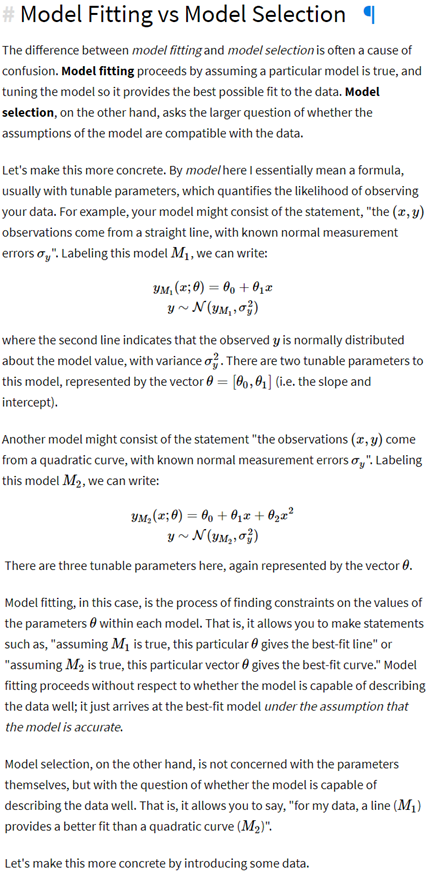

In [2]:
Image(filename="images/5_modelfitvsmodelselect.png")

In [3]:
# PROBLEM TO SOLVE: (model selection): quadratic or linear for this
# data? 


In [5]:
import numpy as np
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                   -0.05, -0.12,  0.26,  0.29,  0.39,
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data

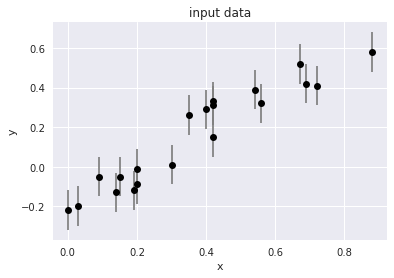

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles

x, y, sigma_y = data
fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.set(xlabel='x', ylabel='y', title='input data');

In [6]:

# If the theta variable is of length 2, this corresponds to the 
# linear model (M1M1). If the theta variable is length 3, this 
# corresponds to the quadratic model (M2M2).

def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

In [7]:
# As detailed in the previous posts, both the frequentist and 
# Bayesian approaches to model fitting often revolve around 
# the likelihood, which, for independent errors, is the product 
# of the probabilities for each individual point. Here is a function 
# which computes the log-likelihood for the two models:

from scipy import stats

def logL(theta, model=polynomial_fit, data=data):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

In [8]:
# need to maximize the log likelihood:

from scipy import optimize

def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, model, data)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

theta1 = best_theta(1)
theta2 = best_theta(2)

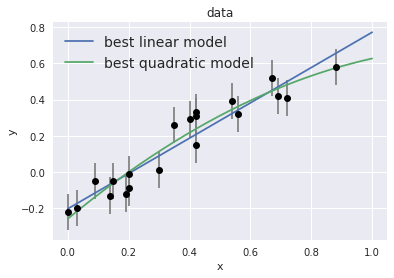

In [9]:
# Let's now we can visually compare the maximum-likelihood 
# degree-1 and degree-2 models:

xfit = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [10]:
# One common mistake is to assume that we can select between 
# models via the value of the maximum likelihood. While this 
# works in some special cases, it is not generally applicable. 
# Let's take a look at 
# the maximum log-likelihood value for each of our fits:

print("linear model:    logL =", logL(best_theta(1)))
print("quadratic model: logL =", logL(best_theta(2)))

# The quadratic model yields a higher log-likelihood, but this 
# does not necessarily mean it is the better model!

# The problem is that the quadratic model has more degrees of 
# freedom than the linear model, and thus will always give
#  an equal or larger maximum likelihood, regardless of the 
# data! This trend holds generally: as you increase model 
# complexity, the maximum likelihood value will (almost) 
# always increase!

linear model:    logL = 22.0108670066
quadratic model: logL = 22.9415135865


In [13]:
# Let's take a look at the best maximum likelihood for a 
# series of polynomial fits (linear, quadratic, cubic, quartic, etc.):

degrees = np.arange(1, 10)
thetas = [best_theta(d) for d in degrees]
logL_max = [logL(theta) for theta in thetas]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(degrees, logL_max)
ax[0].set(xlabel='degree', ylabel='log(Lmax)')
ax[1].errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ylim = ax[1].get_ylim()
for (degree, theta) in zip(degrees, thetas):
    if degree not in [1, 2, 9]: continue
    ax[1].plot(xfit, polynomial_fit(theta, xfit),
               label='degree={0}'.format(degree))
ax[1].set(ylim=ylim, xlabel='x', ylabel='y')
ax[1].legend(fontsize=14, loc='best');

# We see in the left panel that the maximum likelihood value always 
# increases as we increase the degree of the polynomial. Looking at
#  the right panel, we see how this metric has led us astray: while 
# the ninth order polynomial certainly leads to a larger 
# likelihood, it achieves this by over-fitting the data.

# Thus, in some ways, you can view the model selection question 
# as fundamentally about comparing models while 
# correcting for over-fitting of more complicated models. Let's 
# see how this is done within the frequentist and Bayesian 
# approaches.